In [1]:
import os
from pathlib import Path
project_root = os.path.join(str(Path.home()) + '/Documents', 'PPGADev')
os.chdir(project_root)
%pwd # should be PPGA root dir

'/home/icaros/Documents/PPGADev'

In [2]:
import pickle

import numpy as np
from attrdict import AttrDict
from RL.ppo import *
from utils.utilities import log
from envs.brax_custom.brax_env import make_vec_env_brax
from models.actor_critic import Actor, PGAMEActor
from pandas import DataFrame

from IPython.display import HTML, Image
from IPython.display import display
from brax.io import html, image

In [3]:
# params to config
device = torch.device('cuda')
# env_name = 'humanoid'
env_name = 'ant'
seed = 1111
normalize_obs = True
normalize_rewards = True
# non-configurable params
obs_shapes = {
    'humanoid': (227,),
    'ant': (87,),
    'halfcheetah': (18,),
    'walker2d': (17,)
}
action_shapes = {
    'humanoid': (17,),
    'ant': (8,),
    'halfcheetah': (6,),
    'walker2d': (6,)
}

# define the final config objects
actor_cfg = AttrDict({
        'obs_shape': obs_shapes[env_name],
        'action_shape': action_shapes[env_name],
        'normalize_obs': normalize_obs,
        'normalize_rewards': normalize_rewards,
})
env_cfg = AttrDict({
        'env_name': env_name,
        'env_batch_size': None,
        'num_dims': 2 if not 'ant' in env_name else 5,
        'envs_per_model': 1,
        'seed': seed,
        'num_envs': 1,
        'clip_obs_rew': False,
        'is_energy_measures': True
})


In [4]:
# now lets load in a saved archive dataframe and scheduler
# change this to be your own checkpoint path
archive_path = 'experiments/paper_ppga_ant/1111/checkpoints/cp_00001390/archive_df_00001390.pkl'
scheduler_path = 'experiments/paper_ppga_ant/1111/checkpoints/cp_00001390/scheduler_00001390.pkl'
with open(archive_path, 'rb') as f:
    archive_df = pickle.load(f)
# with open(scheduler_path, 'rb') as f:
#     scheduler = pickle.load(f)

In [5]:
from ribs.archives import GridArchive
all_solutions = archive_df.solution_batch()
all_objectives = archive_df.objective_batch()
all_measures = archive_df.measures_batch()
all_metadata = archive_df.metadata_batch()
print(all_solutions.shape)

archive = GridArchive(
    solution_dim=all_solutions.shape[1],  # Dimensionality of solutions in the archive.
    dims=[10, 10, 10, 10, 10],  # 50 cells along each dimension.
    ranges=[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 8.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
    qd_offset=3.24,  # See the note below.
)
# archive.add(all_solutions, all_objectives, all_measures)

(22346, 28816)


In [6]:
archive.add(all_solutions[0:1000], all_objectives[0:1000], all_measures[0:1000], all_metadata[0:1000])

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [7]:
i = 1001
end = min(i + 1000, all_solutions.shape[0])
while i < all_solutions.shape[0]:
    end = min(i + 1000, all_solutions.shape[0])
    archive.add(all_solutions[i:end], all_objectives[i:end], all_measures[i:end], all_metadata[i:end])
    print(i, " to ", end)
    i += 1000
    

1001  to  2001
2001  to  3001
3001  to  4001
4001  to  5001
5001  to  6001
6001  to  7001
7001  to  8001
8001  to  9001
9001  to  10001
10001  to  11001
11001  to  12001
12001  to  13001
13001  to  14001
14001  to  15001
15001  to  16001
16001  to  17001
17001  to  18001
18001  to  19001
19001  to  20001
20001  to  21001
21001  to  22001
22001  to  22346


In [8]:
# create the environment
env = make_vec_env_brax(env_cfg)

feet contact, is_energy_measures =  True
env step fn
<function ant_step at 0x7fc42628b0d0>
feet contact and energy


In [9]:
def get_best_elite():
    best_elite = archive.best_elite
    print(f'Loading agent with reward {best_elite.objective} and measures {best_elite.measures}')
    agent = Actor(obs_shape=actor_cfg.obs_shape[0], action_shape=actor_cfg.action_shape, normalize_obs=normalize_obs, normalize_returns=normalize_rewards).deserialize(best_elite.solution).to(device)
    print("elite metadata")
    print(best_elite.metadata)
    if actor_cfg.normalize_obs:
        norm = best_elite.metadata['obs_normalizer']
        if isinstance(norm, dict):
            agent.obs_normalizer.load_state_dict(norm)
        else:
            agent.obs_normalizer = norm
    return agent

In [10]:
def get_random_elite():
#     elite = scheduler.archive.sample_elites(1)
    elite = archive.sample_elites(1)
    print(f'Loading agent with reward {elite.objective[0]} and measures {elite.measures[0]}')
    agent = Actor(obs_shape=actor_cfg.obs_shape[0], action_shape=actor_cfg.action_shape, normalize_obs=normalize_obs, normalize_returns=normalize_rewards).deserialize(elite.solution_batch.flatten()).to(device)
    if actor_cfg.normalize_obs:
        norm = elite.metadata['obs_normalizer']
        if isinstance(norm, dict):
            agent.obs_normalizer.load_state_dict(norm)
        else:
            agent.obs_normalizer = norm
    return agent

In [11]:
def get_elite(measures):
#     elite = scheduler.archive.elites_with_measures_single(measures)
    elite = archive.elites_with_measures_single(measures)
    print(f'Loading agent with reward {elite.objective} and measures {elite.measures}')
    agent = Actor(obs_shape=actor_cfg.obs_shape[0], action_shape=actor_cfg.action_shape, normalize_obs=normalize_obs, normalize_returns=normalize_rewards).deserialize(elite.solution.flatten()).to(device)
    print("elite")
    print(elite)
    print("elite metadata")
    print(elite.metadata)
    if actor_cfg.normalize_obs:
        norm = elite.metadata['obs_normalizer']
        if isinstance(norm, dict):
            agent.obs_normalizer.load_state_dict(norm)
        else:
            agent.obs_normalizer = norm
    return agent

In [12]:
def enjoy_brax(agent, render=True, deterministic=True):
    if actor_cfg.normalize_obs:
        obs_mean, obs_var = agent.obs_normalizer.obs_rms.mean, agent.obs_normalizer.obs_rms.var
        print(f'{obs_mean=}, {obs_var=}')

    obs = env.reset()
    rollout = [env.unwrapped._state]
    total_reward = 0
    measures = torch.zeros(env_cfg.num_dims).to(device)
    done = False
    while not done:
        with torch.no_grad():
            obs = obs.unsqueeze(dim=0).to(device)
            if actor_cfg.normalize_obs:
                obs = (obs - obs_mean) / torch.sqrt(obs_var + 1e-8)

            if deterministic:
                act = agent.actor_mean(obs)
            else:
                act, _, _ = agent.get_action(obs)
            act = act.squeeze()
            obs, rew, done, info = env.step(act.cpu())
            measures += info['measures']
            rollout.append(env.unwrapped._state)
            total_reward += rew
    if render:
        i = HTML(html.render(env.unwrapped._env.sys, [s.qp for s in rollout]))
        display(i)
        print(f'{total_reward=}')
        print(f' Rollout length: {len(rollout)}')
        measures /= len(rollout)
        print(f'Measures: {measures.cpu().numpy()}')
    return total_reward.detach().cpu().numpy()

In [13]:
# agent = get_random_elite()
print("line")
print("line")
agent = get_best_elite()
enjoy_brax(agent, render=True, deterministic=True)

line
line
Loading agent with reward 6854.8231200850805 and measures [0.1715     0.1736     0.17780001 0.0191     2.21228838]
elite metadata
{'traj_length': 1000.0, 'obs_normalizer': OrderedDict([('obs_rms.mean', tensor([ 6.6041e-01,  7.1664e-01, -1.8820e-02, -3.4076e-02,  2.0513e-01,
        -1.1114e-01,  7.0083e-01,  1.7134e-02, -7.2488e-01,  1.3983e-01,
        -7.0273e-01,  4.2781e-04,  6.8632e-01,  3.4609e+00, -1.5498e-01,
        -1.5806e-02,  8.4385e-03,  9.3121e-02,  2.1631e-02,  2.4130e-03,
        -6.7357e-02,  1.4047e-02,  1.4312e-01,  2.6718e-02,  8.7433e-02,
         1.2458e-02, -3.1002e-02,  5.1302e-05,  4.2944e-05,  8.7864e-02,
         7.6478e-09,  7.6478e-09,  7.6478e-09,  6.7260e-02,  9.9186e-02,
         1.7794e-01,  7.6478e-09,  7.6478e-09,  7.6478e-09, -1.6333e-01,
         2.3365e-02,  2.2122e-01,  7.6478e-09,  7.6478e-09,  7.6478e-09,
         7.2526e-03, -1.1058e-01,  1.8345e-01,  7.6478e-09,  7.6478e-09,
         7.6478e-09,  5.4610e-03, -3.0740e-03,  9.0911e-02

total_reward=tensor(7544.5986, device='cuda:0')
 Rollout length: 1001
Measures: [0.15684316 0.14685315 0.16283716 0.004995   2.0096314 ]


array(7544.5986, dtype=float32)

In [29]:
agent2 = get_elite([0.2, 0, 0.2, 0.2, 6.0])
enjoy_brax(agent2, render=True, deterministic=True)

Loading agent with reward 123.99478485956789 and measures [0.24759999 0.0749     0.255      0.23290001 5.79746008]
elite
Elite(solution=array([-1.74413824, -2.22054815, -1.63082814, ..., -0.0991016 ,
       -0.19848812,  0.17532329]), objective=123.99478485956789, measures=array([0.24759999, 0.0749    , 0.255     , 0.23290001, 5.79746008]), index=20227, metadata={'traj_length': 1000.0, 'obs_normalizer': OrderedDict([('obs_rms.mean', tensor([ 5.3365e-01,  6.4243e-01, -1.3142e-02, -2.6573e-02,  1.5540e-01,
        -6.1851e-02,  8.4363e-01, -6.8059e-02, -7.6327e-01,  7.5830e-02,
        -7.8531e-01, -1.8509e-01,  8.9519e-01,  7.8653e-01,  4.0057e-03,
        -7.3501e-03,  1.3669e-01,  1.8240e-03,  3.7938e-01,  5.8475e-01,
        -2.2925e-02,  5.8734e-01,  1.1966e-01,  5.6785e-01,  7.7747e-02,
         5.5858e-01,  4.9310e-02,  5.9256e-05, -1.1781e-04,  7.3313e-02,
         7.0308e-10,  7.0308e-10,  7.0308e-10, -2.8144e-02,  9.1809e-02,
         3.7333e-01,  7.0308e-10,  7.0308e-10,  7.03

total_reward=tensor(-48.7665, device='cuda:0')
 Rollout length: 1001
Measures: [0.06893107 0.04495504 0.05594406 0.05494505 5.4743743 ]


array(-48.766518, dtype=float32)

/home/icaros/Documents/PPGA/pyribs/ribs/visualize.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return matplotlib.cm.get_cmap(cmap)
/home/icaros/Documents/PPGA/pyribs/ribs/visualize.py:782: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  host_ax.figure.colorbar(mappable,


<function matplotlib.pyplot.show(close=None, block=None)>

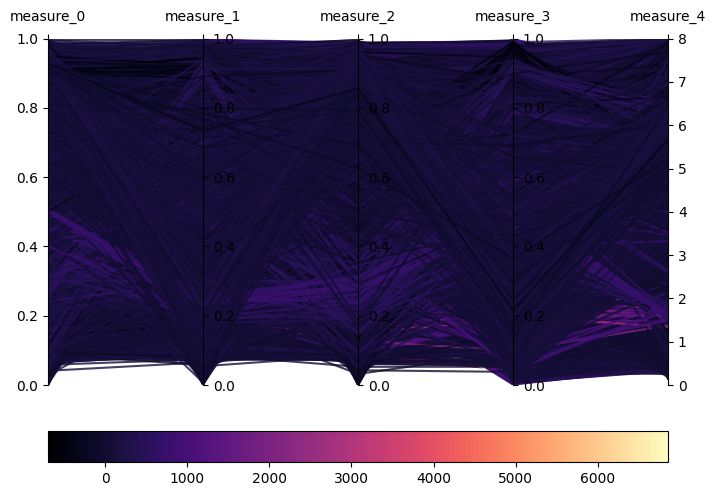

In [15]:
import matplotlib.pyplot as plt
from ribs.visualize import parallel_axes_plot
plt.figure(figsize=(8, 6))
parallel_axes_plot(archive)
plt.show